# EXP 20. 난 스케치를 할 테니 너는 채색을 하거라

**GAN과 cGAN 비교해보기**

## 1. 데이터 준비하기
`pip install tensorflow-datasets`

In [20]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

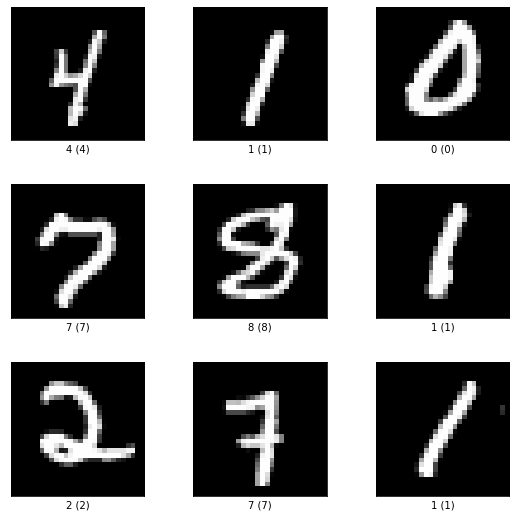

In [1]:
mnist, info =  tfds.load("mnist", split="train", with_info=True)
fig = tfds.show_examples(mnist, info)

In [3]:
"""
이미지 픽셀값을 -1 ~ 1사이의 범위로 변경
레이블 정보를 원-핫 인코딩
"""
BATCH_SIZE = 128

# GAN - label x
def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # image pixel -1~1
    return image

  # cGAN - label o
def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)  # 레이블 원핫인코딩
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


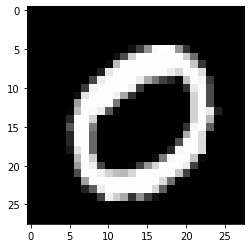

In [5]:
for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

<br><br><br>

# 2. Generator 구성

## 2-1. GAN Generator

In [7]:
class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')
        
        self.reshape = layers.Reshape((28,28,1))
        
    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

## 2-2. cGAN Generator
1. 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU활성화를 통과한다.(dense_z, dense_y)
2. 1번 각 결과를 연결하여 다시 한번 1개의 fully-connected 레이어와 ReLU활성화를 통과한다. (tf.concat, conbined_dense)
3. 2번 결과가 1개의 fully-connected 레이어 및 Hyperbolic t_dangent활성화를 거쳐 28x28차원의 결과가 생성되고 (28,28,1)크기의 이미지 형태로 변환되어 출력된다.(final_dense, reshape)

In [9]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28*28*1, activation='tanh')
        self.reshape = layers.Reshape((28,28,1))
        
    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

<br><br><br>

# 3. Discriminator 구성

## 3-1. GAN Discriminator

In [10]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(layers.Dense(f, activation=None if f==1 else "relu"))
    
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

## 3-2. cGAN Discriminator

In [11]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation='relu')  #  # units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만듬
        self.dropout = layers.Dropout(0.5)
        self.reshape = layers.Reshape((-1, pieces, units))
        
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)  # 최대값 출력

In [12]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

<br><br><br>

# 4. 학습 및 테스트

## 4-1. loss function, optimizer 정의
- Binary Cross Entropy
- Adam optimizer

In [15]:
bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

## 4-2. GAN으로 MNIST 학습

In [16]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [17]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.374802827835083, D:0.10847366601228714
[1/10 EPOCHS, 200 ITER] G:2.6203672885894775, D:0.145212322473526
[1/10 EPOCHS, 300 ITER] G:2.8194174766540527, D:0.13110098242759705
[1/10 EPOCHS, 400 ITER] G:3.1314287185668945, D:0.1581839621067047
[2/10 EPOCHS, 100 ITER] G:4.245237350463867, D:0.07253583520650864
[2/10 EPOCHS, 200 ITER] G:3.0108413696289062, D:0.13378745317459106
[2/10 EPOCHS, 300 ITER] G:3.061915874481201, D:0.09644405543804169
[2/10 EPOCHS, 400 ITER] G:3.410912036895752, D:0.14093419909477234
[3/10 EPOCHS, 100 ITER] G:3.525507926940918, D:0.1252283900976181
[3/10 EPOCHS, 200 ITER] G:3.3031346797943115, D:0.10176387429237366
[3/10 EPOCHS, 300 ITER] G:4.151298999786377, D:0.20605367422103882
[3/10 EPOCHS, 400 ITER] G:4.049345970153809, D:0.18678978085517883
[4/10 EPOCHS, 100 ITER] G:3.696164131164551, D:0.1445351094007492
[4/10 EPOCHS, 200 ITER] G:3.8348965644836426, D:0.04726447910070419
[4/10 EPOCHS, 300 ITER] G:4.3658857345581055, D:0.08814525604

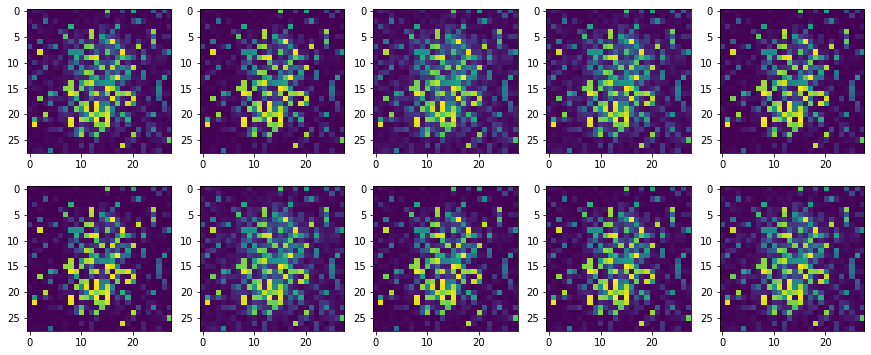

In [19]:
noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

**500 epoch 학습한 가중치 불러와 학습**

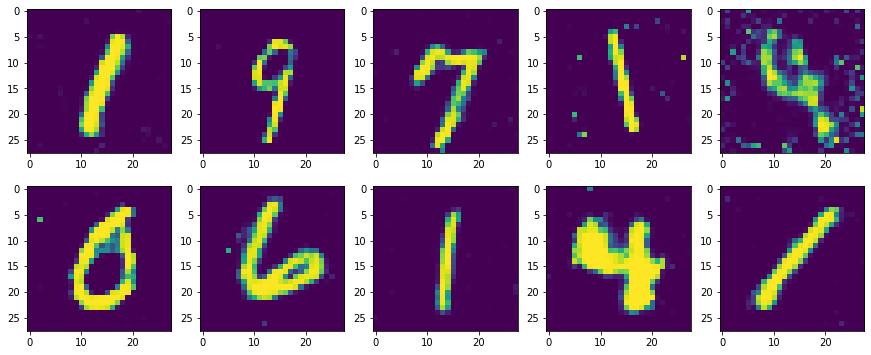

In [21]:
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## 4-3. cGAN으로 MNIST 학습

In [22]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss

In [23]:
EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:4.353172779083252, D:0.026135507971048355
[1/1 EPOCHS, 199 ITER] G:3.6125216484069824, D:0.06299609690904617
[1/1 EPOCHS, 299 ITER] G:4.516088008880615, D:0.01627628318965435
[1/1 EPOCHS, 399 ITER] G:3.349191904067993, D:0.14262017607688904


**500 epoch 학습한 가중치 불러와 학습**

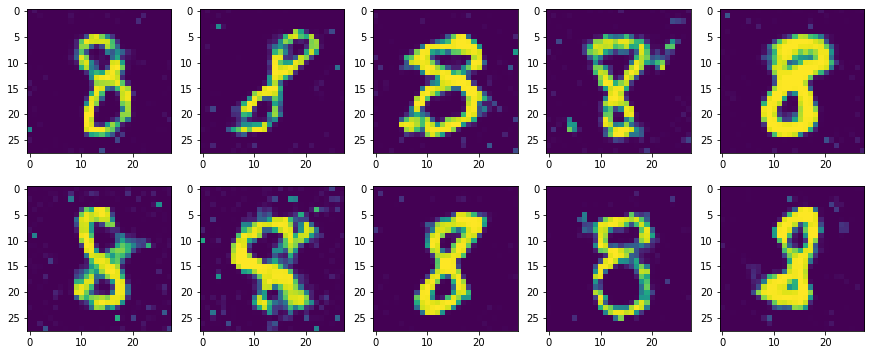

In [24]:
number = 8  # 생성할 숫자

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])